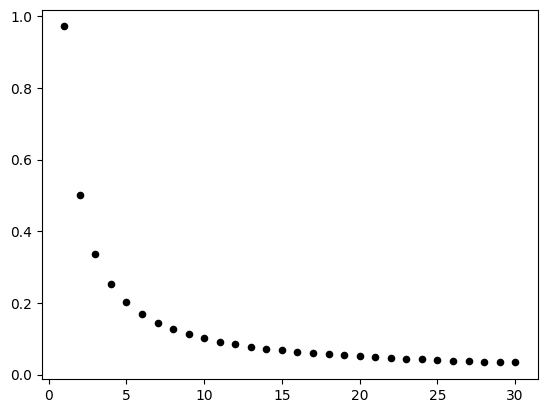

In [75]:
import numpy as np
import matplotlib.pyplot as plt

"""
Calculer le champ sur une ligne
===============================

La ligne est verticale (en y) et je regarde sur l'axe (y=0) en x

J'ai une ligne de charges de longueur L, discrétisée en N sous-éléments de longueur L/(N-1)
(le N-1 vient du fait que j'inclus L/2 dans la liste de valeurs).

Je veux une charge totale qui ne change pas en terme du nombre N,
donc si q = L * densité, alors densité=q/L, et dq = densité * dl,
puisque la ligne est L est en y' (en y et c'est une source), dl = dy'

"""

L = 1          # Grandeur de la ligne en y
N = 101        # Nombre de sources discrètes sur la ligne
Y_prime = np.linspace(-L/2, L/2, N, endpoint=True ) # Valeurs en y sur la ligne
dy_prime = Y_prime[1]-Y_prime[0]

q_total = 1
densite_charge = q_total/L

distance = 30*L
M = 30
X = np.linspace(distance/M, distance, M, endpoint=True)
V = np.zeros(M) # Potentiel sur la ligne x

for i, x in enumerate(X):
  for y_prime in Y_prime:
    r = np.sqrt(x*x+y_prime*y_prime)
    V[i] += (densite_charge*dy_prime)/r


plt.scatter(X, V, 20, "k")
plt.show()
